# TCLab Close loop with PID and FF
## Imports

In [1]:
import numpy as np
import tclab
import time
from datetime import datetime
import os

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import package_DBR
import package_LAB

from importlib import reload
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode
from package_LAB import LL_RT, PID_RT,IMC_Tuning, FF_RT
package_LAB=reload(package_LAB)

## Parameters

In [2]:
Ts = 1


TSim = 500
Ts = 1
N = int(TSim / Ts) + 1

# DV MV PV 
DV0 = 40
MV0 = 100
PV0=40

# paramètres de ^P(s) 2eme ordre pouvant être considérer comme premier ordre 

Kp = 0.57353288531197
T1p = 184.504684095101
T2p= 1.78243605751087E-07
thetap=6.19336906382859

# paramètres de ^D(s) 2ème ordre 
Kd = 0.553358040201031
T1d= 172.259419274141
T2d= 22.1508608750117
thetad =0.533716544751782

#rapport des gains 
KFF = -Kd/Kp

#Coef PID
alpha= 2
gamma = 0.9
Kc,T_I,T_D = IMC_Tuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')
print('Kc : ',Kc,'T_I : ',T_I,'T_D',T_D )

#limites
MV_MIN = 0
MV_MAX = 100

Kc :  1.9373102059878127 T_I :  184.5046842733446 T_D 1.78243605578892e-07


## Vectors

In [3]:
Exp = True

t = []
MV = []
PV = []
DV = []
i = 0

t = []
SP = []
DV = []
PV = []
E = []
MV = []
MV_P = []
MV_I = []
MV_D = []
MAN = []
MV_MAN = []

MVFFDelay = []
MVFFLL1 = []
MV_FF = []

PV_LL1 = []
PV_LL2 = []

MVDelayp = []
PV1p = []
PV2p = []

DVDelayd = []
PV1d = []
PV2d = []




## Path mode selection

In [4]:
# Select mode 

#selectmode="CLP_Rp_SP_NO_FF"
#selectmode="Rp_DV_NO_FF_C_Man"
#selectmode="Rp_DV_FF_C_Man"
#selectmode="Rp_DV_NO_FF_C_Auto"
selectmode="Rp_DV_FF_C_Auto"

In [5]:
if selectmode=="CLP_Rp_SP_NO_FF": 
    # Closed loop response to a SP change
    ManPath = {0: False, TSim: False}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, 300: PV0 + 10, TSim: PV0 + 10}
    DVPath = {0: DV0, 150: DV0 + 20, 200:DV0 , TSim: DV0 + 20}
    FF = False
    ManFF = False
    
elif selectmode=="Rp_DV_NO_FF_C_Man":
    # Response to DV : No FF and controller in manual mode
    ManPath = {0: False, 1: True, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, 300: PV0, TSim: PV0}
    DVPath = {0: DV0, 150: DV0 + 20, 200:DV0, TSim: DV0 + 20}
    FF = False
    ManFF = True
    
elif selectmode=="Rp_DV_FF_C_Man":
    # Response to DV : FF and controller in manual mode
    ManPath = {0: False, 1: True, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, 300: PV0, TSim: PV0}
    DVPath = {0: DV0, 150: DV0 + 20, 200:DV0, TSim: DV0 + 20}
    FF = True
    ManFF = True
    
elif selectmode=="Rp_DV_NO_FF_C_Auto":
    
    # Response to DV : No FF and controller in automatic mode
    ManPath = {0: False, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, 300: PV0, TSim: PV0}
    DVPath = {0: DV0, 150: DV0 + 20, 200:DV0, TSim: DV0 + 20}
    FF = False
    ManFF = False
    
elif selectmode=="Rp_DV_FF_C_Auto":
    
    # Response to DV : FF and controller in automatic mode
    ManPath = {0: False, TSim: False}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, 300: PV0, TSim: PV0}
    DVPath = {0: DV0, 150: DV0 + 20, 200:DV0 , TSim: DV0 + 20}
    FF = True
    ManFF = False

## Experimentation

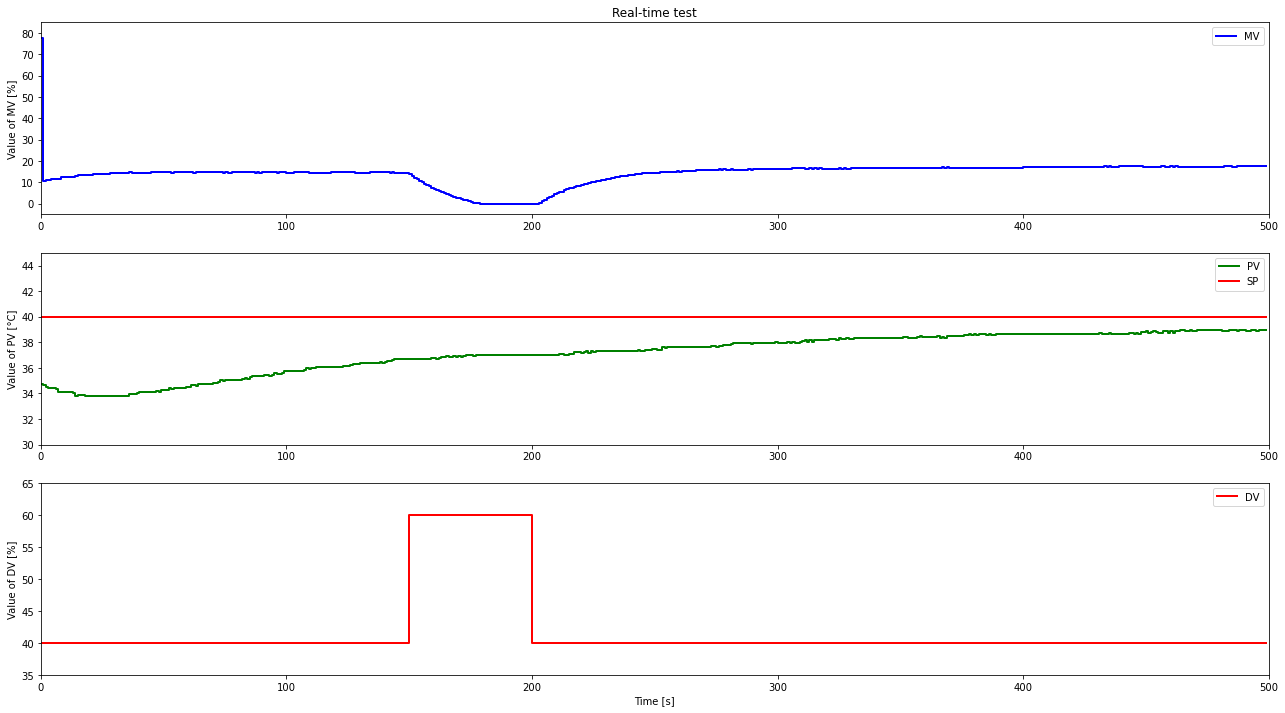

TCLab disconnected successfully.


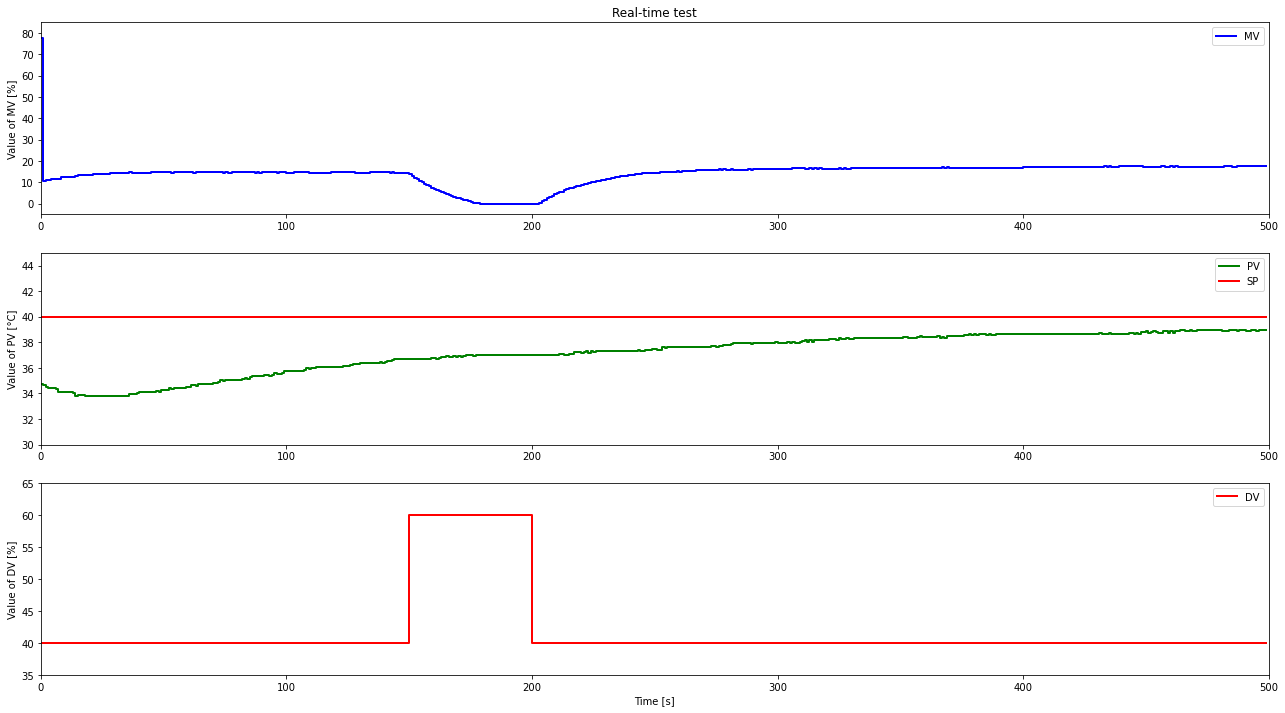

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.set_figheight(12)
fig.set_figwidth(22)

l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='MV',where='post')
ax1.set_ylabel('Value of MV [%]')
ax1.set_title('Real-time test')
ax1.legend(loc='best')

l2, = ax2.step([0,1],[0,100],'g-',linewidth=2,label='PV',where='post')
l4, = ax2.step([0,1],[0,100],'r-',linewidth=2,label='SP',where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')

l3, = ax3.step([0,1],[0,100],'r-',linewidth=2,label='DV',where='post')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Value of DV [%]')
ax3.legend(loc='best') 

lab = tclab.TCLab()



# Experiment is started
while Exp:
    t.append(i*Ts)
    
    # SP et DV creation
    SelectPath_RT(SPPath, t, SP)
    SelectPath_RT(DVPath,t,DV)
    
     #feedforward 

    if FF== True:
        FF_RT(DV, thetad, thetap, Ts, MVFFDelay, KFF, T1p, T1d, MVFFLL1, T2p, T2d, MV_FF, DV0)
    else:
        LL_RT(DV,0,T2p,T2d,Ts,MV_FF)
    
    #mode manuel
    SelectPath_RT(ManPath,t,MAN)
    SelectPath_RT(MVManPath,t,MV_MAN)
    
    #PID
    PID_RT(SP,PV,MAN,MV_MAN,MV_FF,Kc,T_I,T_D,alpha,Ts,MV_MAX,MV_MIN,MV,MV_P,MV_I,MV_D,E,FF)
    
    
    
    
    
    lab.Q1(MV[-1])
    lab.Q2(DV[-1])
    
    
    PV.append(lab.T1)
    time.sleep(Ts)
    
    
    
    
    
    
    l1.set_data(t,MV)
    l2.set_data(t,PV)
    l3.set_data(t,DV)
    l4.set_data(t,SP)
    
    clear_output(wait=True)    
    
    # Remove if increasing x-axis length is not desired
    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    
    if i > 1:
        ax1.set_ylim(myRound(np.min(MV),5)-5, myRound(np.max(MV),5)+5)
        ax2.set_ylim(myRound(np.min(PV),5)-5, myRound(np.max(PV),5)+5)
        ax3.set_ylim(myRound(np.min(DV),5)-5, myRound(np.max(DV),5)+5)    
    
    display(fig)     
    
    i = i + 1
    
    if i == TSim:
        Exp = False
        lab.close()

# Save data in text file
# ----------------------
now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")
# Conversion to array
t = np.array(t) 
MV = np.array(MV)
PV = np.array(PV)
DV = np.array(DV)        
my_data = np.vstack((t.T,MV.T,PV.T,DV.T))
my_data = my_data.T
nameFile = 'Data/RT_test_on_' + date_time + '.txt'
if not os.path.exists('Data'):
    os.makedirs('Data')
np.savetxt(nameFile,my_data,delimiter=',',header='t,MV,PV,DV',comments='')        


# Save Plot
# ---------
if not os.path.exists('Plots'):
    os.makedirs('Plots')

titleName = 'RT_test_on_' + date_time
plt.savefig('Plots\\' + titleName + '.png',transparent=True)
plt.savefig('Plots\\' + titleName + '.pdf',transparent=True)
    